### S2S_FNO_GPT_hidden_states (pretrained)
1. Loading a pretrained FNO (from fno_hidden_compression.pth or similar).
2. Injecting it into a GPT-based model that does triplet token prediction.
3. Training only the GPT (or both GPT & FNO if you prefer) on the triplet-level next-token task.
4. Using single-nucleotide sequences as input to the FNO => producing embeddings => fused into GPT.

Below is a single Python script that loads the pretrained FNO (the one you previously trained with higher accuracy) and injects it into the GPT fusion workflow. This replaces the old “FourierNeuralOperator” definition with the loaded FNO parameters.  We then use that loaded FNO to generate embeddings and fuse them into the GPT model for triplet-based next-token prediction.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Example script:
1) Loads a pretrained FNO (fno_hidden_compression.pth).
2) Uses it inside a GPT to produce fused embeddings for triplet-based DNA tokens.
3) Trains the GPT (and optionally the FNO) for next-token prediction on triplet codons.
   - Single-nucleotide sequences are fed to the FNO.
   - The FNO output is fused into GPT embeddings for codon-level tokens.
4) Logs training/validation loss, perplexity, accuracy, and uses early stopping.
5) Saves the final model.

Ensure the following files exist:
- Homo_sapiens.GRCh38.dna.chromosome.Y.fa   (the FASTA from which we chunk sequences)
- fno_hidden_compression.pth                (the pretrained FNO checkpoint)
"""

import os
import re
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


In [2]:
###############################################################################
# 1) FASTA => 768-bp Chunks
###############################################################################
def parse_fasta_and_chunk(fasta_path, chunk_size=768, max_samples=25000):
    seq_parts = []
    with open(fasta_path, 'r') as f:
        for line in f:
            if line.startswith(">"):
                continue
            seq_parts.append(line.strip())
    full_seq = "".join(seq_parts).upper()

    # If you want codon alignment
    remainder = len(full_seq) % 3
    if remainder != 0:
        full_seq = full_seq[:-remainder]

    chunks = [full_seq[i : i + chunk_size] for i in range(0, len(full_seq), chunk_size)]
    chunks = [c for c in chunks if len(c) == chunk_size]

    if len(chunks) > max_samples:
        random.shuffle(chunks)
        chunks = chunks[:max_samples]
    return chunks

def build_dna_dataframe(dna_chunks):
    return pd.DataFrame(dna_chunks, columns=["dna_sequence"])


In [3]:
###############################################################################
# 2) Triplet Codon Tokenization
###############################################################################
def tokenize_triplets(dna_str):
    codons = [dna_str[i : i + 3] for i in range(0, len(dna_str), 3)]
    valid = set([
        'AAA','AAT','AAG','AAC','ATA','ATT','ATG','ATC',
        'AGA','AGT','AGG','AGC','ACA','ACT','ACG','ACC',
        'TAA','TAT','TAG','TAC','TTA','TTT','TTG','TTC',
        'TGA','TGT','TGG','TGC','TCA','TCT','TCG','TCC',
        'GAA','GAT','GAG','GAC','GTA','GTT','GTG','GTC',
        'GGA','GGT','GGG','GGC','GCA','GCT','GCG','GCC',
        'CAA','CAT','CAG','CAC','CTA','CTT','CTG','CTC',
        'CGA','CGT','CGG','CGC','CCA','CCT','CCG','CCC','N'
    ])
    return [c if c in valid else '<unk>' for c in codons]

def build_triplet_vocab(tokenized_list):
    all_tokens = set()
    for seq in tokenized_list:
        all_tokens.update(seq)
    all_tokens = sorted(list(all_tokens))
    char_to_idx = {tok: i + 1 for i, tok in enumerate(all_tokens)}
    char_to_idx['<pad>'] = 0
    idx_to_char = {v: k for k, v in char_to_idx.items()}
    return char_to_idx, idx_to_char

def encode_triplets(dna_str, char_to_idx):
    tokens = tokenize_triplets(dna_str)
    return [char_to_idx.get(t, char_to_idx.get('<unk>', 0)) for t in tokens]

In [4]:
###############################################################################
# 3) Single-nuc for FNO
###############################################################################
dna_pattern = re.compile(r"[ATGCN]")

def tokenize_single_nuc(seq):
    return dna_pattern.findall(seq.upper())

def build_single_nuc_vocab():
    """
    Minimal => {<pad>:0, A:1, T:2, G:3, C:4}  # Remove N to match pretrained
    """
    return {'<pad>': 0, 'A':1, 'T':2, 'G':3, 'C':4}

def encode_single_nuc(seq, nuc_vocab):
    tokens = tokenize_single_nuc(seq)
    return [nuc_vocab.get(t, 0) for t in tokens]

def one_hot_encode(seq_idx, vocab_size):
    arr = np.zeros((len(seq_idx), vocab_size), dtype=np.float32)
    for i, idx in enumerate(seq_idx):
        arr[i, idx] = 1.0
    return arr

In [5]:
###############################################################################
# 4) Pretrained FNO: We'll load it from disk
###############################################################################
class ImprovedFourierLayer(nn.Module):
    def __init__(self, modes, width):
        super().__init__()
        self.modes = modes
        self.width = width
        self.scale = 1.0 / (width**2)

        self.weights_real = nn.Parameter(self.scale * torch.randn(modes, width))
        self.weights_imag = nn.Parameter(self.scale * torch.randn(modes, width))
        # Change layernorm to norm to match pretrained
        self.norm = nn.LayerNorm(width)  # Changed from layernorm
        self.dropout = nn.Dropout(0.0)

    def forward(self, x):
        residual = x
        # Update this line too
        x = self.norm(x.transpose(1,2)).transpose(1,2)

        x_ft = torch.fft.rfft(x, dim=-1)
        x_ft = x_ft[:, :, :self.modes]

        out_ft = torch.zeros_like(x_ft, dtype=torch.cfloat)
        out_ft.real = x_ft.real * self.weights_real.unsqueeze(0).transpose(1, 2)
        out_ft.imag = x_ft.imag * self.weights_imag.unsqueeze(0).transpose(1, 2)

        x_out = torch.fft.irfft(out_ft, n=x.size(-1), dim=-1)
        x_out = self.dropout(x_out)
        return x_out + residual

class PretrainedFNO(nn.Module):
    def __init__(self, modes, width, input_dim, output_dim, n_layers=3):
        super().__init__()
        self.fc_in = nn.Linear(input_dim, width)
        self.f_layers = nn.ModuleList([
            ImprovedFourierLayer(modes, width) for _ in range(n_layers)
        ])
        self.norm_out = nn.LayerNorm(width)
        self.fc_out = nn.Linear(width, output_dim)
        self.activation = nn.GELU()

    def forward(self, x):
        # x shape: (batch, seq_len, input_dim)
        x = self.fc_in(x)             # => (batch, seq_len, width)
        x = self.activation(x)
        x = x.transpose(1, 2)         # => (batch, width, seq_len)
        
        for layer in self.f_layers:
            x = layer(x)
            
        x = x.transpose(1, 2)         # => (batch, seq_len, width)
        x = self.norm_out(x)
        x = self.fc_out(x)            # => (batch, seq_len, output_dim)
        x = x.mean(dim=1)             # => (batch, output_dim)
        return x

In [6]:
###############################################################################
# 5) GPT for Triplets (Concat-Fusion)
###############################################################################
class PositionalEncoding(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        max_len = 1024
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(-torch.arange(0, d_model, 2).float() * (math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :].to(x.device)
        return x

class DNAGPT_Triplet_Fusion(nn.Module):
    def __init__(self, vocab_size=100, embedding_dim=512, nhead=8, num_layers=4, dropout=0.1):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.pos_encoder = PositionalEncoding(embedding_dim)

        # Fix: Adjust fusion layer dimensions - we're concatenating two 512-d vectors
        self.fusion_linear = nn.Linear(embedding_dim * 2, embedding_dim)
        
        enc_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            batch_first=True,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(embedding_dim, vocab_size)

    def forward(self, src, fno_emb=None):
        # src => (batch, seq_len)
        # fno_emb => (batch, 512)
        batch_size = src.size(0)
        seq_len = src.size(1)
        
        x = self.token_embedding(src)  # => (batch, seq_len, 512)
        x = self.pos_encoder(x)        # => (batch, seq_len, 512)

        if fno_emb is not None:
            # Fix: Reshape FNO embeddings and ensure dimensions match
            fno_emb = fno_emb.view(batch_size, -1)  # Ensure shape (batch, 512)
            # Expand to match sequence length
            fno_expanded = fno_emb.unsqueeze(1).expand(-1, seq_len, -1)
            # Concatenate along feature dimension
            x = torch.cat([x, fno_expanded], dim=-1)  # => (batch, seq_len, 1024)
            # Project back to embedding dimension
            x = self.fusion_linear(x)  # => (batch, seq_len, 512)

        mask = self.generate_square_subsequent_mask(seq_len).to(src.device)
        x = self.transformer_encoder(x, mask=mask)
        x = self.dropout(x)
        logits = self.fc_out(x)  # => (batch, seq_len, vocab_size)
        return logits

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
        return mask

In [7]:
###############################################################################
# 6) Combined FNO+GPT Model
###############################################################################
class FNOPlusGPT(nn.Module):
    def __init__(self, fno, gpt):
        super().__init__()
        self.fno = fno
        # Adapter to match GPT embedding dimension
        self.dim_adapter = nn.Linear(128, 512)
        self.gpt = gpt

    def forward(self, src, fno_input=None):
        # Process FNO input if provided
        if fno_input is not None:
            fno_emb = self.fno(fno_input)
            fno_emb = self.dim_adapter(fno_emb)
        else:
            fno_emb = None
            
        # Forward through GPT
        return self.gpt(src, fno_emb=fno_emb)

In [8]:
###############################################################################
# 7) Dataset
###############################################################################
class FNOGPTDataset(Dataset):
    """
    For each chunk => single-nuc => FNO => embedding => GPT => next-codon
    We do next-token pred in GPT on the codon sequence.
    """
    def __init__(self, df, nuc_vocab, trip_vocab, max_trip_len=85):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.nuc_vocab = nuc_vocab
        self.trip_vocab = trip_vocab
        self.max_trip_len = max_trip_len

        self.nuc_encoded = []            # list of single-nucleotide ID arrays
        self.trip_encoded_padded = []    # list of codon-level ID arrays (with padding)

        for seq in self.df["dna_sequence"]:
            # single-nuc
            nuc_idx = encode_single_nuc(seq, self.nuc_vocab)
            self.nuc_encoded.append(nuc_idx)

            # trip
            trip_idx = encode_triplets(seq, self.trip_vocab)
            pad_len = self.max_trip_len - len(trip_idx)
            trip_idx += [0]*pad_len
            self.trip_encoded_padded.append(trip_idx)

        self.trip_encoded_padded = torch.tensor(self.trip_encoded_padded, dtype=torch.long)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        nuc_seq = self.nuc_encoded[idx]
        trip_seq = self.trip_encoded_padded[idx]
        # GPT next-token:
        input_seq = trip_seq[:-1]
        target_seq = trip_seq[1:]
        return nuc_seq, input_seq, target_seq

def fnogpt_collate_fn(batch):
    nuc_list = []
    gpt_in_list = []
    gpt_tgt_list = []
    for (nuc_seq, in_seq, tgt_seq) in batch:
        nuc_list.append(nuc_seq)
        gpt_in_list.append(in_seq)
        gpt_tgt_list.append(tgt_seq)
    gpt_in_tensor = torch.stack(gpt_in_list, dim=0)   # (batch, seq_len)
    gpt_tgt_tensor = torch.stack(gpt_tgt_list, dim=0) # (batch, seq_len)
    return nuc_list, gpt_in_tensor, gpt_tgt_tensor

In [9]:
###############################################################################
# 8) Training and Evaluation
###############################################################################
def compute_accuracy(logits, targets, pad_idx=0):
    with torch.no_grad():
        preds = logits.argmax(dim=-1).view(-1)
        targets = targets.view(-1)
        mask = (targets != pad_idx)
        correct = (preds[mask] == targets[mask]).sum().item()
        total = mask.sum().item()
        return correct / total if total > 0 else 0.0

def train_epoch(model, loader, optimizer, criterion, device, pad_idx=0):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    total_samples = 0

    for nuc_seq_list, gpt_in, gpt_tgt in loader:
        batch_sz = gpt_in.size(0)
        gpt_in = gpt_in.to(device)
        gpt_tgt = gpt_tgt.to(device)

        # Process FNO inputs
        emb_list = []
        for nuc_seq in nuc_seq_list:
            arr = one_hot_encode(nuc_seq, 5)  # 5 for nucleotide vocab size
            x_tensor = torch.tensor(arr, dtype=torch.float32).to(device)
            x_tensor = x_tensor.unsqueeze(0)  # Add batch dimension
            emb_list.append(x_tensor)
        
        # Stack all FNO inputs
        fno_inputs = torch.cat(emb_list, dim=0)  # (batch, seq_len, 5)

        optimizer.zero_grad()
        # Forward pass through entire model
        logits = model(gpt_in, fno_input=fno_inputs)
        
        logits_flat = logits.view(-1, logits.size(-1))
        gpt_tgt_flat = gpt_tgt.view(-1)
        
        loss = criterion(logits_flat, gpt_tgt_flat)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_sz
        acc = compute_accuracy(logits, gpt_tgt, pad_idx)
        total_acc += acc * batch_sz
        total_samples += batch_sz

    return total_loss/total_samples, math.exp(total_loss/total_samples), total_acc/total_samples

@torch.no_grad()
def eval_epoch(model, loader, criterion, device, pad_idx=0):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total_samples = 0

    for nuc_seq_list, gpt_in, gpt_tgt in loader:
        batch_sz = gpt_in.size(0)
        gpt_in = gpt_in.to(device)
        gpt_tgt = gpt_tgt.to(device)

        # Process FNO inputs
        emb_list = []
        for nuc_seq in nuc_seq_list:
            arr = one_hot_encode(nuc_seq, 5)
            x_tensor = torch.tensor(arr, dtype=torch.float32).to(device)
            x_tensor = x_tensor.unsqueeze(0)
            emb_list.append(x_tensor)
        
        fno_inputs = torch.cat(emb_list, dim=0)

        # Forward pass
        logits = model(gpt_in, fno_input=fno_inputs)
        
        logits_flat = logits.view(-1, logits.size(-1))
        gpt_tgt_flat = gpt_tgt.view(-1)
        
        loss = criterion(logits_flat, gpt_tgt_flat)

        total_loss += loss.item() * batch_sz
        acc = compute_accuracy(logits, gpt_tgt, pad_idx)
        total_acc += acc * batch_sz
        total_samples += batch_sz

    return total_loss/total_samples, math.exp(total_loss/total_samples), total_acc/total_samples

class EarlyStopping:
    def __init__(self, patience=15, verbose=False, delta=0, path='fno_gpt_unfrozen_best.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss decreased ({self.loss_min:.6f} -> {val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.path)
        self.loss_min = val_loss


Using device: mps
Loaded chunks: 25000
Train: 20000 Val: 5000
Triplet vocab size: 66


/var/folders/fw/cd1vxk4x57b1f2cpwmt7g49800k_fc/T/ipykernel_86300/624341712.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(fno_ckpt_path, map_lo

Loaded pretrained FNO from: fno_hidden_compression.pth
Using PRETRAINED FNO + GPT for triplet prediction.
Epoch 1: TrainLoss=1.8131, ValLoss=1.7649, TrainPPL=6.13, ValPPL=5.84, TrainAcc=0.566, ValAcc=0.576
Validation loss decreased (inf -> 1.764881). Saving model...
Epoch 2: TrainLoss=1.7742, ValLoss=1.7377, TrainPPL=5.90, ValPPL=5.68, TrainAcc=0.574, ValAcc=0.582
Validation loss decreased (1.764881 -> 1.737672). Saving model...
Epoch 3: TrainLoss=1.7372, ValLoss=1.6985, TrainPPL=5.68, ValPPL=5.47, TrainAcc=0.582, ValAcc=0.591
Validation loss decreased (1.737672 -> 1.698507). Saving model...
Epoch 4: TrainLoss=1.7107, ValLoss=1.6842, TrainPPL=5.53, ValPPL=5.39, TrainAcc=0.588, ValAcc=0.594
Validation loss decreased (1.698507 -> 1.684214). Saving model...
Epoch 5: TrainLoss=1.6924, ValLoss=1.6694, TrainPPL=5.43, ValPPL=5.31, TrainAcc=0.591, ValAcc=0.597
Validation loss decreased (1.684214 -> 1.669370). Saving model...
Epoch 6: TrainLoss=1.6755, ValLoss=1.6582, TrainPPL=5.34, ValPPL=5.25

/var/folders/fw/cd1vxk4x57b1f2cpwmt7g49800k_fc/T/ipykernel_86300/624341712.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fno_gpt_un

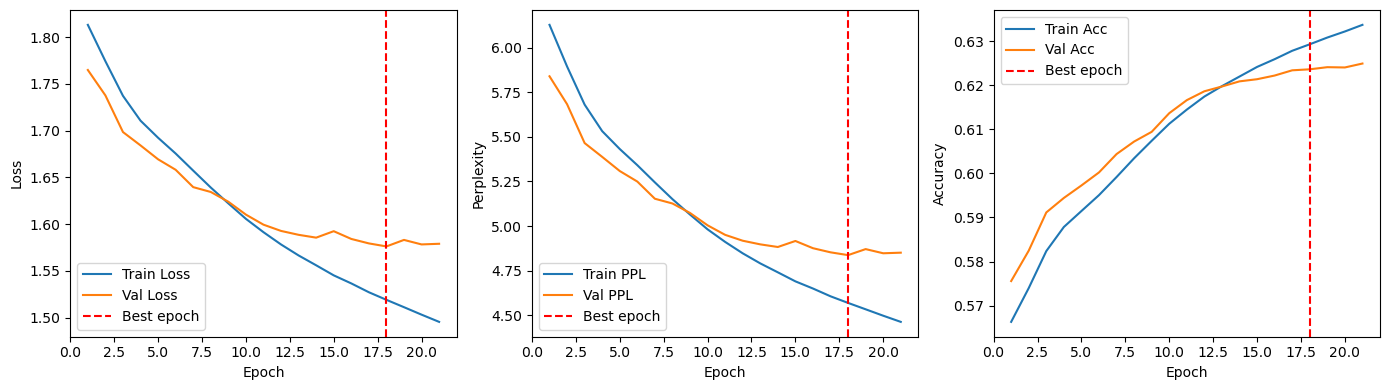

Saved final PRETRAINED-FNO+GPT model to 'fno_gpt_unfrozen_final.pt'.


In [11]:
###############################################################################
# 9) MAIN
###############################################################################
def main():
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    device = torch.device('mps' if torch.mps.is_available() else 'cpu')
    print("Using device:", device)

    # A) FASTA => 768
    fasta_path= "Homo_sapiens.GRCh38.dna.chromosome.Y.fa"
    if not os.path.exists(fasta_path):
        raise FileNotFoundError(f"{fasta_path} not found")
    dna_chunks= parse_fasta_and_chunk(fasta_path, chunk_size=768, max_samples=25000)
    print("Loaded chunks:", len(dna_chunks))

    df_full= build_dna_dataframe(dna_chunks)
    df_train, df_val= train_test_split(df_full, test_size=0.2, random_state=42)
    print("Train:", len(df_train),"Val:", len(df_val))

    # B) Build triplet vocab
    all_trip= [tokenize_triplets(seq) for seq in df_full["dna_sequence"]]
    trip_char2idx, trip_idx2char= build_triplet_vocab(all_trip)
    vocab_size= len(trip_char2idx)
    print("Triplet vocab size:", vocab_size)

    # single-nuc vocab => e.g. 6 tokens
    nuc_vocab= build_single_nuc_vocab()

    # find max #codons in the train set
    max_trip_len= max(len(encode_triplets(seq, trip_char2idx)) for seq in df_train["dna_sequence"])
    train_dataset= FNOGPTDataset(df_train, nuc_vocab, trip_char2idx, max_trip_len)
    val_dataset=   FNOGPTDataset(df_val,   nuc_vocab, trip_char2idx, max_trip_len)

    train_loader= DataLoader(
        train_dataset, batch_size=8, shuffle=True, collate_fn=fnogpt_collate_fn
    )
    val_loader= DataLoader(
        val_dataset,   batch_size=8, shuffle=False, collate_fn=fnogpt_collate_fn
    )

    # C) Load the Pretrained FNO from disk
    #    Suppose the file is "fno_hidden_compression.pth" from your previous script
    fno_model = PretrainedFNO(
        modes=12,        
        width=48,        
        input_dim=5,     # Change from 6 to 5 to match pretrained
        output_dim=128,  # Change from 512 to 128 to match pretrained
        n_layers=3
    ).to(device)

    # Load pretrained weights
    fno_ckpt_path = "fno_hidden_compression.pth"  # Adjust if needed
    if not os.path.exists(fno_ckpt_path):
        raise FileNotFoundError(f"{fno_ckpt_path} not found. Please provide the trained FNO model.")
    state_dict = torch.load(fno_ckpt_path, map_location=device)
    fno_model.load_state_dict(state_dict)
    print("Loaded pretrained FNO from:", fno_ckpt_path)

    # Optionally freeze the FNO
    # for param in fno_model.parameters():
    #     param.requires_grad = False

    # D) Define GPT
    gpt_model= DNAGPT_Triplet_Fusion(
        vocab_size=vocab_size,
        embedding_dim=512,
        nhead=8,
        num_layers=4,
        dropout=0.1
    ).to(device)

    # E) Combine => we have a model that has (fno + gpt)
    model= FNOPlusGPT(fno_model, gpt_model).to(device)
    print("Using PRETRAINED FNO + GPT for triplet prediction.")

    # F) Training Setup
    optimizer= optim.AdamW(model.parameters(), lr=1e-4)
    criterion= nn.CrossEntropyLoss(ignore_index=trip_char2idx['<pad>'])
    early_stopper= EarlyStopping(patience=3, verbose=True, path="fno_gpt_unfrozen_best.pt")

    # G) Training Loop
    epochs= 40
    train_losses, val_losses= [], []
    train_ppls, val_ppls= [], []
    train_accs, val_accs= [], []

    for ep in range(1, epochs+1):
        tr_loss, tr_ppl, tr_acc = train_epoch(model, train_loader, optimizer, criterion, device, pad_idx=0)
        va_loss, va_ppl, va_acc = eval_epoch(model, val_loader, criterion, device, pad_idx=0)

        train_losses.append(tr_loss)
        val_losses.append(va_loss)
        train_ppls.append(tr_ppl)
        val_ppls.append(va_ppl)
        train_accs.append(tr_acc)
        val_accs.append(va_acc)

        print(f"Epoch {ep}: "
              f"TrainLoss={tr_loss:.4f}, ValLoss={va_loss:.4f}, "
              f"TrainPPL={tr_ppl:.2f}, ValPPL={va_ppl:.2f}, "
              f"TrainAcc={tr_acc:.3f}, ValAcc={va_acc:.3f}")

        early_stopper(va_loss, model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load best
    model.load_state_dict(torch.load("fno_gpt_unfrozen_best.pt", map_location=device))
    print("Loaded best checkpoint from 'fno_gpt_unfrozen_best.pt'.")

    # H) Plot
    x_ep= range(1,len(train_losses)+1)
    plt.figure(figsize=(14,4))

    plt.subplot(1,3,1)
    plt.plot(x_ep, train_losses,label='Train Loss')
    plt.plot(x_ep, val_losses,label='Val Loss')
    best_ep= np.argmin(val_losses)+1
    plt.axvline(best_ep, color='r', linestyle='--', label='Best epoch')
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.subplot(1,3,2)
    plt.plot(x_ep, train_ppls,label='Train PPL')
    plt.plot(x_ep, val_ppls,label='Val PPL')
    plt.axvline(best_ep, color='r', linestyle='--', label='Best epoch')
    plt.xlabel("Epoch"); plt.ylabel("Perplexity"); plt.legend()

    plt.subplot(1,3,3)
    plt.plot(x_ep, train_accs,label='Train Acc')
    plt.plot(x_ep, val_accs,label='Val Acc')
    plt.axvline(best_ep, color='r', linestyle='--', label='Best epoch')
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

    plt.tight_layout()
    plt.show()

    # I) Save Final
    torch.save(model.state_dict(),"fno_gpt_unfrozen_final.pt")
    print("Saved final PRETRAINED-FNO+GPT model to 'fno_gpt_unfrozen_final.pt'.")


if __name__=="__main__":
    main()